In [1]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append("/Users/ryan/Desktop/work/school intern/Energy Intern /eco-tools/") #path to PI CLient

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')

# get value from pi

In [24]:
pc = pi_client(root='readonly') #assgin values

In [25]:
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu") #GBSF_ChilledWater_Demand_kBtu
# use electricity data 
points

['GBSF_Electricity_Demand_kBtu']

In [26]:
start = "2017-07-05" 
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'

In [27]:
df = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
df.shape

Grabbing WebIDs ...
WebID collection complete!
15:20:15: Sending API request... Chunk 1 of 1
15:20:17: Response recieved for 1 tags! (1.38)


(17701, 1)

In [28]:
df = df[np.isfinite(df).all(1)]

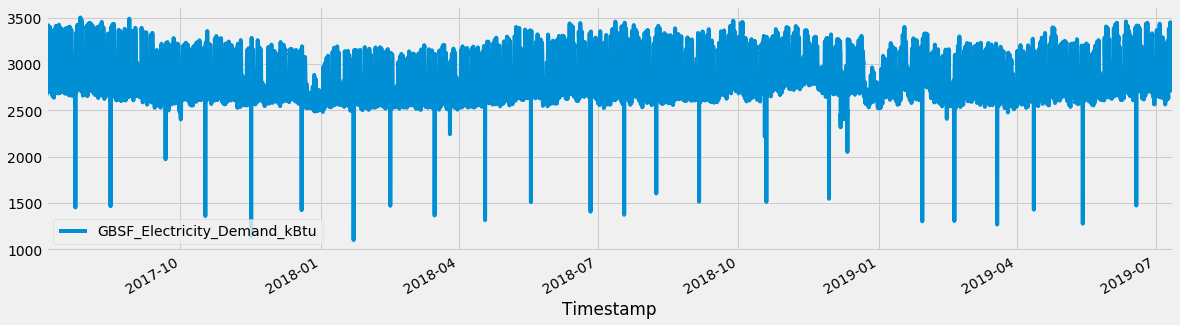

In [29]:
df.plot(figsize = (18,5))
#plt.axhline(y = -4559.555552373463,color="red")
#plt.axhline(y = 9763.775384346645,color="red") #3sd method

# 1.  z-score and 3 sd = 95%

In [30]:
def detect_outlier(df):
    outliers=[]
    threshold=3
    mean_1 = np.mean(df)
    std_1 =np.std(df)
    
    for y in df:
        z_score = (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
            
    return outliers

In [31]:
outlier_datapoints = detect_outlier(df["GBSF_Electricity_Demand_kBtu"])
print(outlier_datapoints)

[1453.3170471191406, 1466.1823455810547, 1973.781532796224, 1360.4095428466796, 1140.9758306545682, 1423.6978698730468, 1100.9191975911458, 1471.6505564371744, 1366.7412007649739, 1316.5795237223308, 1510.3328704833984, 1406.8805694580078, 1373.7094116210938, 1603.5392812093098, 1514.8966013590496, 1512.1701253255208, 1546.9441986083984, 2052.4293416341147, 1303.883280436198, 1306.8043314615886, 1268.9043477376301, 1429.2364298502605, 1277.835205078125, 1473.9635416666667]


# 2. box plot 

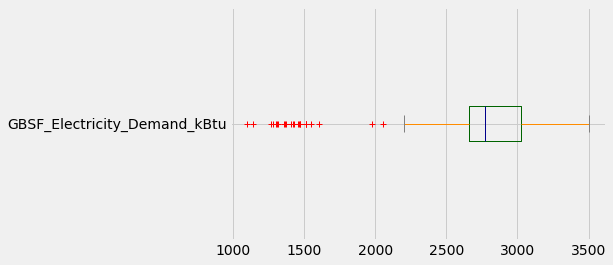

In [32]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange','medians': 'DarkBlue', 'caps': 'Gray'}
df.plot.box(vert=False,color=color, sym='r+')
# 25%, 75%

# 3. density plot

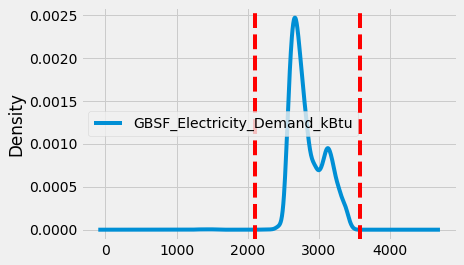

In [33]:
df.plot.kde()
plt.axvline(2107.71747317844, linestyle = '--', color = 'r')
plt.axvline(3577.4252127075197, linestyle = '--', color = 'r')

# 4. percentile

In [34]:
sorted(df)

['GBSF_Electricity_Demand_kBtu']

In [35]:
q1,q3 = df['GBSF_Electricity_Demand_kBtu'].quantile([.25,.75])

In [36]:
iqr = q3 - q1

In [37]:
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

In [38]:
upper_bound 

3579.1584661229463

In [39]:
lower_bound

2106.9356795628864

In [40]:
np.sum(df['GBSF_Electricity_Demand_kBtu'] < 0)

0

In [41]:
mask = (df['GBSF_Electricity_Demand_kBtu'] < 2107.71747317844 )| (df['GBSF_Electricity_Demand_kBtu'] > 3577.4252127075197 )

In [42]:
min(df['GBSF_Electricity_Demand_kBtu'])

1100.9191975911458

In [43]:
anormaly = df.loc[mask]

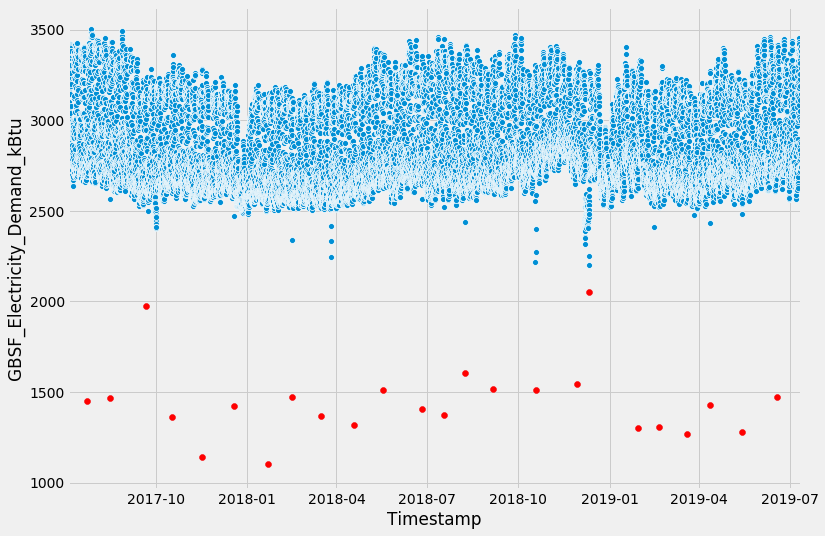

In [44]:
# plot, and if its lower than 25% && higher than 75%, mark them red
plt.xlim(df.index[0], df.index[-1])
plt.gcf().set_size_inches(11.7, 8.27)
ax = sns.scatterplot(x=df.index, y="GBSF_Electricity_Demand_kBtu", data=df)
plt.scatter(x= anormaly[mask].index, 
            y = anormaly[mask]['GBSF_Electricity_Demand_kBtu'], 
            color= 'r')

# 5. k means for clusting

In [45]:
df = df[np.isfinite(df).all(1)]

[[ 2926.          2820.96075835]
 [14712.5         2845.27838586]
 [ 8800.          2857.29221423]]
[5865 5920 5893]


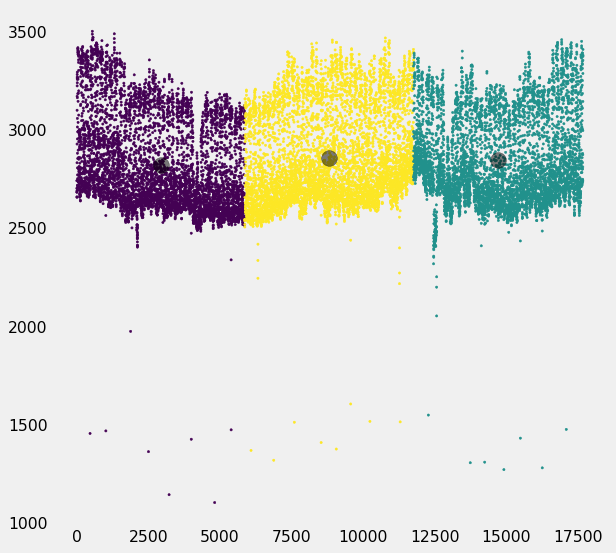

In [46]:
x = range(len(df.index))
y = df["GBSF_Electricity_Demand_kBtu"]
data = np.column_stack([x,y])

kmeans = KMeans(n_clusters=3)
data_transformed = kmeans.fit(data)
y_kmeans = kmeans.predict(data)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=4, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.grid()

print(centers)
print(np.bincount(kmeans.labels_))

In [61]:
type(data)

numpy.ndarray

In [48]:
# FIND THE PROPER number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

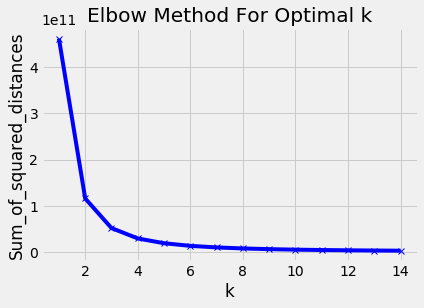

In [49]:
# k is 4, which is a point where the line start to be flat
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 6. agglomerative hierarchical clustering

In [50]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')  
cluster.fit_predict(df) 

array([0, 0, 0, ..., 2, 2, 2])

In [69]:
df[0:]

,GBSF_Electricity_Demand_kBtu
Timestamp,
2017-07-05 00:00:00,2742.115666
2017-07-05 01:00:00,2703.342263
2017-07-05 02:00:00,2683.433364
2017-07-05 03:00:00,2684.103522
2017-07-05 04:00:00,2659.619794
2017-07-05 05:00:00,2657.369491
2017-07-05 06:00:00,2691.471765
2017-07-05 07:00:00,2833.344177
2017-07-05 08:00:00,2928.925806


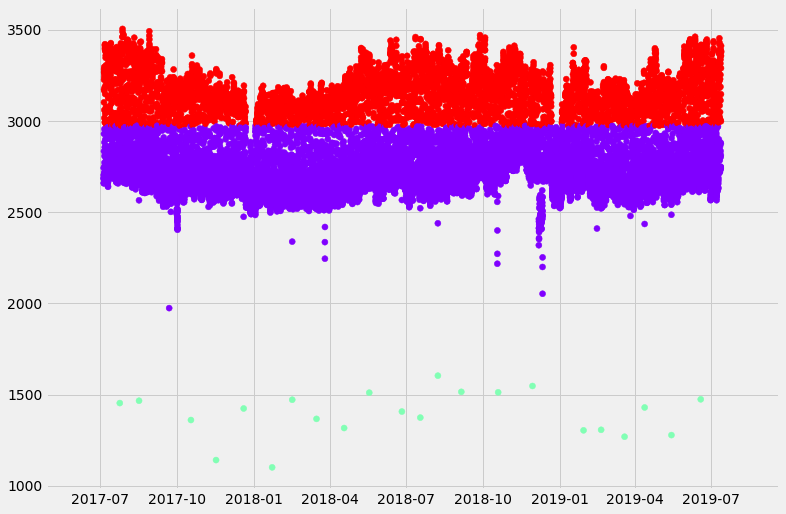

In [51]:
plt.scatter(df.index,df[0:], c=cluster.labels_, cmap='rainbow') 
plt.gcf().set_size_inches(11.7, 8.27)

In [52]:
points = pc.search_by_point("aitit4045") # get outside air tempeture
points

['aiTIT4045']

In [53]:
start = "2017-07-05" 
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'

In [54]:
tp = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
tp.shape

Grabbing WebIDs ...
WebID collection complete!
15:21:24: Sending API request... Chunk 1 of 1
15:21:25: Response recieved for 1 tags! (0.87)


(17701, 1)

In [55]:
result = pd.merge(df, tp, on='Timestamp')

In [76]:
result

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2017-07-05 00:00:00,2742.115666,67.199602
2017-07-05 01:00:00,2703.342263,66.549455
2017-07-05 02:00:00,2683.433364,65.147544
2017-07-05 03:00:00,2684.103522,63.976632
2017-07-05 04:00:00,2659.619794,61.242740
2017-07-05 05:00:00,2657.369491,60.156010
2017-07-05 06:00:00,2691.471765,61.455913
2017-07-05 07:00:00,2833.344177,65.848933
2017-07-05 08:00:00,2928.925806,69.644673


In [56]:
result['label'] = cluster.labels_

In [57]:
unique_cluster_labels_ = np.unique(cluster.labels_.tolist())

In [58]:
outliers = []

for i in unique_cluster_labels_:
    subresult = result.loc[result["label"] == i]
    #threthldold
    #print(subresult.shape)
    #q1, q3= np.percentile(subresult["aiTIT4045"].tolist(),[25,75])

    q1,q3 = result.loc[result['label'] == i].quantile([.25,.75])["aiTIT4045"].unique()
    print("q1: " + str(q1))
    print("q2: " + str(q3))
    print(i)
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 
    print("lower: "+str(lower_bound))
    print("upper: " + str(upper_bound))
    
    mask1 = subresult["aiTIT4045"]<lower_bound
    mask2 = subresult["aiTIT4045"] > upper_bound
    mask = mask1 | mask2
    print(subresult.loc[mask].shape)
    outliers.append(subresult.loc[mask])
    print("\n\n")
    #for j in subresult["aiTIT4045"].tolist():
     #   if j < lower_bound or j > upper_bound:
      #  
       #     outliers.append(j)
    #print(outliers)    
outliersplot = pd.concat(outliers)

q1: 51.80619274020168
q2: 67.19875478184119
0
lower: 28.71734967774242
upper: 90.28759784430045
(252, 3)



q1: 49.41044868606406
q2: 59.22935454219879
1
lower: 34.68208990186196
upper: 73.95771332640089
(1, 3)



q1: 61.34082714632858
q2: 84.7475217938011
2
lower: 26.2307851751198
upper: 119.85756376500987
(0, 3)





In [59]:
outliersplot["label"].unique()

array([0, 1])

In [60]:
outliersplot.groupby(by = "label")

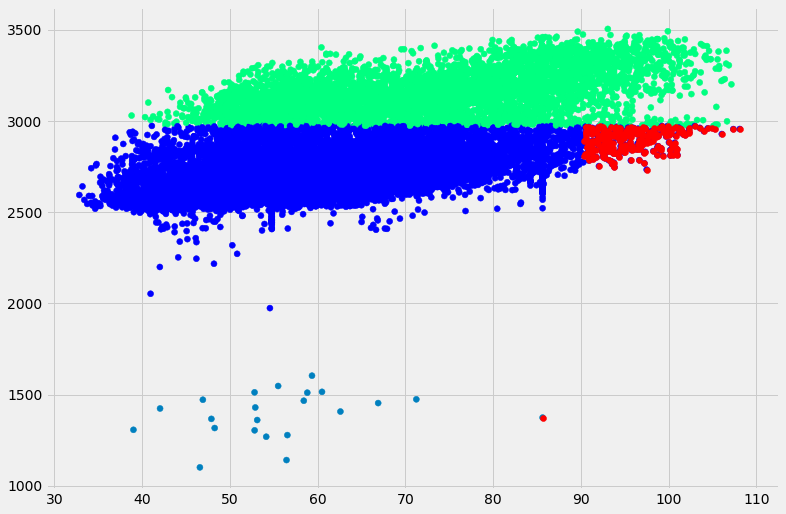

In [62]:
plt.scatter(result.iloc[:,1], result.iloc[:,0],c=cluster.labels_, cmap='winter')
plt.scatter(outliersplot.iloc[:,1],outliersplot.iloc[:,0],c = "red")
plt.gcf().set_size_inches(11.7, 8.27)


In [63]:
# see how many data points in each clusters
np.bincount(cluster.labels_)

array([12613,    22,  5043])

In [64]:
subresult

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,
2017-07-05 09:00:00,3101.260468,73.454433,2
2017-07-05 10:00:00,3172.594159,77.773465,2
2017-07-05 11:00:00,3225.338729,82.469200,2
2017-07-05 12:00:00,3283.581494,86.745086,2
2017-07-05 13:00:00,3265.138552,90.335850,2
2017-07-05 14:00:00,3271.150136,87.051675,2
2017-07-05 15:00:00,3241.205601,88.601903,2
2017-07-05 16:00:00,3295.395679,94.438616,2
2017-07-05 17:00:00,3258.663045,96.336959,2


In [88]:
result['label'].unique()

array([0, 2, 1])

In [89]:
result.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,
2017-07-05 00:00:00,2742.115666,67.199602,0
2017-07-05 01:00:00,2703.342263,66.549455,0
2017-07-05 02:00:00,2683.433364,65.147544,0
2017-07-05 03:00:00,2684.103522,63.976632,0
2017-07-05 04:00:00,2659.619794,61.242740,0


In [90]:
subresult['label'].unique()

array([2])

In [91]:
unique_cluster_labels_ = np.unique(cluster.labels_.tolist())

In [92]:
result.loc[result["label"] == 3]#.isna().count()

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,


In [93]:
result.loc[result["label"] == 2].isna().count()

GBSF_Electricity_Demand_kBtu    3654
aiTIT4045                       3654
label                           3654
dtype: int64

In [94]:
result.loc[result['label'] == 3].quantile([.25,.75])


,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
0.25,NaN,NaN,NaN
0.75,NaN,NaN,NaN


In [95]:
q1,q3 = result.loc[result['label'] == 0].quantile([.25,.75])["aiTIT4045"].unique()
print(q1,q3)

52.20132130142996 68.10799776012198


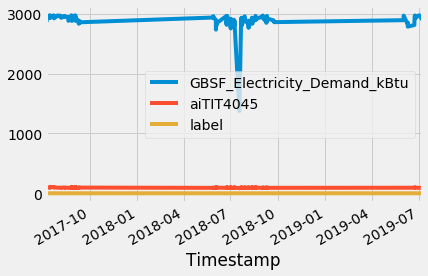

In [65]:
outliersplot.plot()

In [53]:
subresult["aiTIT4045"].tolist()

[66.54945492283444,
 65.1475442774182,
 63.97663175737535,
 61.24273967025657,
 60.15601038272008,
 61.45591287738695,
 65.84893339730623,
 64.57346673631021,
 64.4735398373592,
 62.80280612457167,
 62.69895101566153,
 64.18903374098423,
 65.09854891994425,
 63.93018851909982,
 63.25677852811045,
 65.14226505543911,
 71.40823093134999,
 66.03729581207709,
 64.92710785555343,
 64.9845116534516,
 65.2427221297518,
 65.38763815402113,
 71.48181175546972,
 63.782477724179685,
 63.78438444448107,
 62.84114268705796,
 62.151984207927484,
 62.610662065559225,
 68.41289561571077,
 65.98059960587307,
 64.37914263159007,
 62.78397667489995,
 63.445653135601255,
 63.2700817799191,
 62.97875981227933,
 65.16648126756427,
 70.79797800506375,
 64.4947309090737,
 63.27410836558358,
 63.26035963494158,
 64.78927429767859,
 70.22886423708246,
 64.00022449759037,
 62.452892931015306,
 62.41211521382914,
 61.23953167387275,
 62.75612567526226,
 64.72108939583805,
 62.440413678386165,
 61.716461533381185,

In [19]:
newdf = result[result['label'] == 1]

In [20]:
sortednewdf = sorted(newdf.iloc[:,1])

In [21]:
q1, q3= np.percentile(sortednewdf,[25,75])
iqr = q3 - q1
lower_bound = q1 -(3 * iqr) 
upper_bound = q3 +(3 * iqr) 

In [22]:
np.mean(sortednewdf)

71.60715425310721

In [43]:
print(lower_bound)
print(upper_bound)

62.66887427400448
114.51230930707149


In [85]:
def getbound(df):
    sortdf = sorted(df.iloc[:,1])
    q1 = np.percentile(sortdf,25)
    q3 = np.percentile(sortdf,75)
    iqr = q3 - q1
    lower_bound = q1 -(3 * iqr)
    upper_bound = q3 +(3 * iqr) 
    return lower_bound,upper_bound

In [86]:
newdf2= result[result['label'] == 2]
newdf3= result[result['label'] == 3]
newdf0= result[result['label'] == 0]

In [90]:
print(getbound(newdf2))
print(getbound(newdf3))
print(getbound(newdf0))

(58.51390101917738, 96.5259621604111)
(79.67611350527785, 118.79635482956147)
(nan, nan)


# 7. ARIMA prediction ,  short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

# Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)



In [66]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
# from pyramid.arima import auto_arima : to get d f ,q

result = adfuller(df.iloc[:,0].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# when p is less than 0.05, no d 

ADF Statistic: -14.619926
p-value: 0.000000


In [ ]:
# clean the first half of the GBSF electricity data to be used in training a model (ARIMA, LSTM, RandomForest). 
# For clustering, we don’t really “train” any model so this cleaning doesn’t need to happen.

df_hour = df.resample('1h').sum()

df_clean = df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][0:int(len(df_hour.GBSF_Electricity_Demand_kBtu)/2)]

 

df_clean = df_clean.drop(df_clean[df_clean.values<10000].index, axis=0)

 

df_merge = pd.concat([df_clean, df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][int(len(df_hour.GBSF_Electricity_Demand_kBtu)/2):]], axis=0)

df_merge.sort_index(ascending=True)

df_merge.plot(figsize=(18,5), linewidth=1)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#well above the significance line. 
#Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). 
#But I am going to be conservative and tentatively fix the p as 1.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.iloc[:,0].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.iloc[:,0].diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
#Couple of lags are well above the significance line. So, let’s tentatively fix q as 2.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

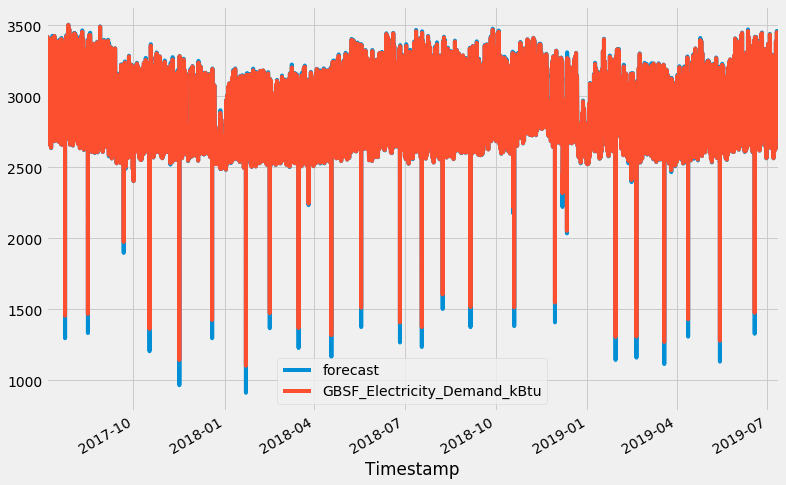

In [67]:
from statsmodels.tsa.arima_model import ARIMA

# fit model, determine the order, p ,q , d 
model = ARIMA(df.iloc[:,0], order=(1,1,0))
model_fit = model.fit(disp=0)
# make prediction
yhat = model_fit.predict(len(df), len(df), typ='levels')
#print(yhat)
model_fit.plot_predict(dynamic=False)
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

In [69]:
np.isnan(df).any()

GBSF_Electricity_Demand_kBtu    False
dtype: bool

In [70]:
a = residuals.iloc[:,0]

In [71]:
q1 = np.percentile(a,25)
q3 = np.percentile(a,75)
iqr = q3 - q1
lower_bound = q1 -(3 * iqr)
upper_bound = q3 +(3 * iqr) 
print(lower_bound,upper_bound)

-193.2002703650349 185.94116159046385


In [72]:
a = (residuals[0]<-731.4373630122202) | (residuals[0]>752.3136825850719)
residual_outliers = residuals.loc[a]
new_residual_outliers = residual_outliers.values.tolist()
new_residual_outliers

[[-1288.8967492838594],
 [1503.2803325279888],
 [-1086.6987457612624],
 [1518.454314222936],
 [843.9792048731014],
 [-1279.3079905277236],
 [1480.9234512287096],
 [-1442.0593762915248],
 [1679.8144927039693],
 [-1037.749045760904],
 [1527.2132350755164],
 [-1556.9622864004084],
 [1720.8356839680719],
 [-843.6591330710233],
 [1304.1893951407449],
 [-1142.4569311863097],
 [1426.2711952186273],
 [-1248.484160225911],
 [1495.5352530453054],
 [-1115.3927896750129],
 [1451.8262616174777],
 [-1149.998691007773],
 [1531.4519032431958],
 [-1132.0694258755818],
 [1575.99049102843],
 [-814.7557136507869],
 [1295.076159443997],
 [-1159.219057344124],
 [1324.8071874743637],
 [-1062.376213206429],
 [1432.3818527215583],
 [-1136.1668925146512],
 [1482.7151737455638],
 [-800.2273210382475],
 [-1311.0613051292587],
 [1666.6754137533514],
 [-1204.372856081667],
 [1590.2886645902686],
 [-1263.8910083779529],
 [1662.5135979353431],
 [-972.4210354414545],
 [1361.8040140905327],
 [-1200.4291232331211],
 [15

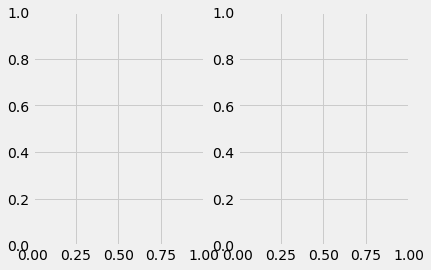

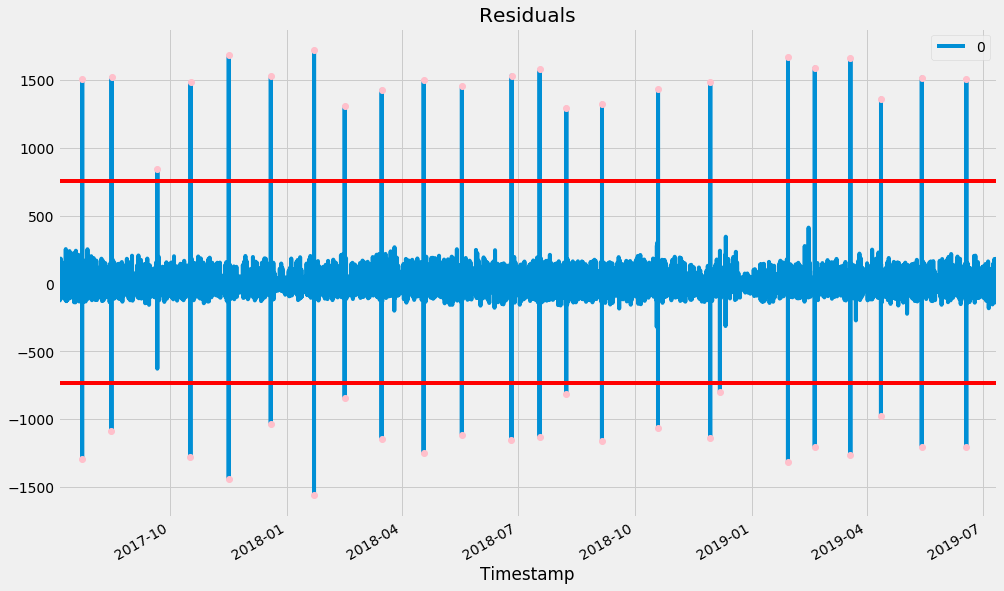

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

residuals = pd.DataFrame(model_fit.resid)
fig, axes = plt.subplots(1,2)
residuals.plot(title="Residuals")
# mark the outliers and show in the graph
for outlier in new_residual_outliers:
    residual_index = residuals.values.tolist().index(outlier)
    date_residual_index = residuals.index[residual_index]
    plt.plot(date_residual_index, outlier, color = 'pink', marker = 'o')
#residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.gcf().set_size_inches(15, 10)
# add residual slit lines
plt.axhline(y = -731.4373630122202,color="red")
plt.axhline(y = 752.3136825850719,color="red")
plt.show()

In [74]:
a = residuals.iloc[:,0]

In [75]:
q1 = np.percentile(a,25)
q3 = np.percentile(a,75)
iqr = q3 - q1
lower_bound = q1 -(3 * iqr)
upper_bound = q3 +(3 * iqr) 
print(lower_bound,upper_bound)

-193.2002703650349 185.94116159046385


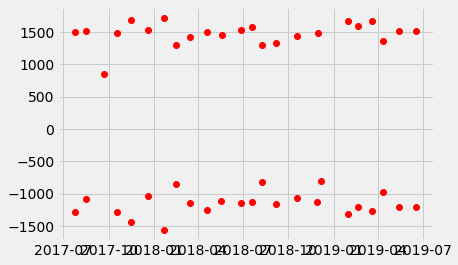

In [76]:
#get all residual outliers in a list: residual_outliers
#plt.plot(r)
for outlier in new_residual_outliers:
    residual_index = residuals.values.tolist().index(outlier)
    date_residual_index = residuals.index[residual_index]
    plt.plot(date_residual_index, outlier, color = 'red', marker = 'o')

In [77]:
a = (residuals[0]<-731.4373630122202) | (residuals[0]>752.3136825850719)
residual_outliers = residuals.loc[a]
new_residual_outliers = residual_outliers.values.tolist()
new_residual_outliers


[[-1288.8967492838594],
 [1503.2803325279888],
 [-1086.6987457612624],
 [1518.454314222936],
 [843.9792048731014],
 [-1279.3079905277236],
 [1480.9234512287096],
 [-1442.0593762915248],
 [1679.8144927039693],
 [-1037.749045760904],
 [1527.2132350755164],
 [-1556.9622864004084],
 [1720.8356839680719],
 [-843.6591330710233],
 [1304.1893951407449],
 [-1142.4569311863097],
 [1426.2711952186273],
 [-1248.484160225911],
 [1495.5352530453054],
 [-1115.3927896750129],
 [1451.8262616174777],
 [-1149.998691007773],
 [1531.4519032431958],
 [-1132.0694258755818],
 [1575.99049102843],
 [-814.7557136507869],
 [1295.076159443997],
 [-1159.219057344124],
 [1324.8071874743637],
 [-1062.376213206429],
 [1432.3818527215583],
 [-1136.1668925146512],
 [1482.7151737455638],
 [-800.2273210382475],
 [-1311.0613051292587],
 [1666.6754137533514],
 [-1204.372856081667],
 [1590.2886645902686],
 [-1263.8910083779529],
 [1662.5135979353431],
 [-972.4210354414545],
 [1361.8040140905327],
 [-1200.4291232331211],
 [15

# 8. linear regression model

Text(0.5, 1.0, 'Data Without Outliers')

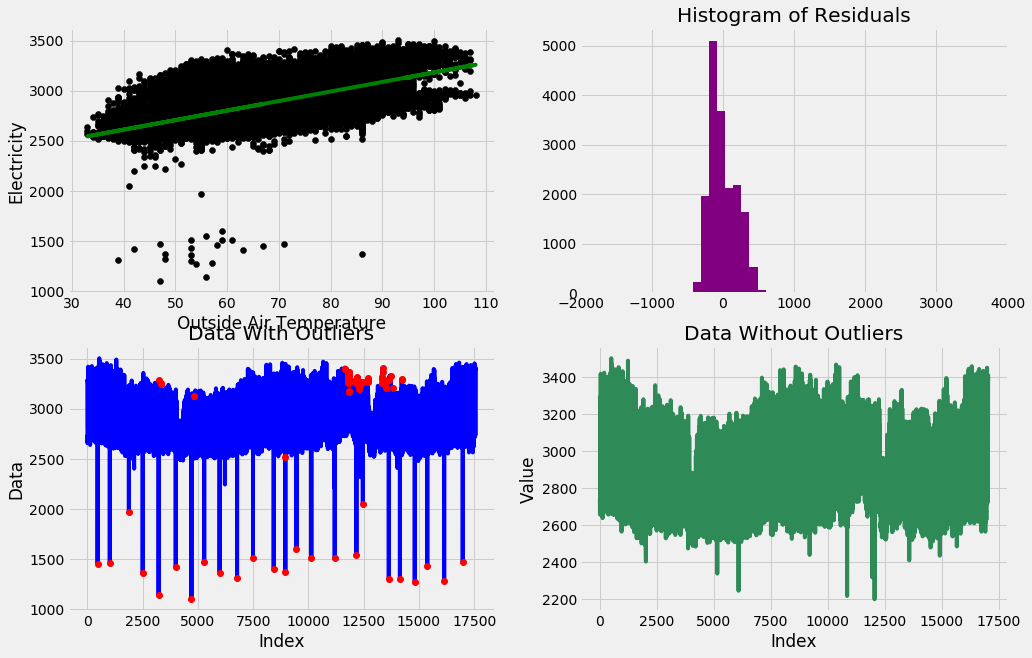

In [78]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

#pull data - df is chilled water, df2 is outside air temperatue
new_df = pd.merge_asof(df, tp, on = "Timestamp")
#drop any NA values
new_df = new_df.dropna()


#round columns
for col in new_df.columns[1:3]:
   new_df[col] = new_df[col].apply(lambda x: round(x, 0))
#reshape the data so you can use it in the linear reg. model
#here is where you would apply x^2
x =  np.array(new_df.iloc[:, 2]).reshape(-1, 1)
y = np.array(new_df.iloc[:, 1]).reshape(-1, 1)
lnn = LinearRegression().fit(x, y)
#the linear model's fitted predictions
preds = lnn.intercept_ + lnn.coef_ * x
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
#the residuals: actual chilled water - predicted
residuals = (y - preds).reshape(-1, 1)
upper_bound = np.mean(residuals) + 2.5*np.std(residuals)
lower_bound = np.mean(residuals) - 2.5*np.std(residuals)
indexes = []
for i in range(len(residuals)):
   residual = residuals[i]
   if residual > upper_bound or residual < lower_bound:
       indexes.append(i)
y = np.ravel(y).tolist()
outliers = [y[i] for i in indexes]
plt.scatter(x, y, color = "black")
plt.plot(x, preds, color = "green", linewidth=4)
plt.xlabel("Outside Air Temperature")
plt.ylabel("Electricity")
plt.subplot(2, 2, 2)
#plot residuals
plt.hist(residuals, color = "purple", bins = 20)
plt.xlim([-2000, 4000])
plt.title("Histogram of Residuals")
plt.subplot(2, 2, 3)
plt.plot(y, color = "blue")
for i in indexes:
   outlier = y[i]
   plt.plot(i, outlier, color = "red", marker = "o")
plt.xlabel("Index")
plt.ylabel("Data")
plt.title("Data With Outliers")
#retrieve data without outliers
new_data = [x for x in y if x not in outliers]
plt.subplot(2, 2, 4)
plt.plot(new_data, color = "seagreen")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Data Without Outliers")
